In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import datetime as dt
import dateutil.easter as ea
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import CCA
import xgboost as xgb
import scipy.stats as stats
import matplotlib.pyplot as plt
import multiprocessing
import seaborn as sns
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2 import robjects
here = importr("here")
CCA_r = importr("CCA")
CCP = importr("CCP")
GGally = importr("GGally")
dplyr = importr("dplyr")
readr = importr("readr")
purrr = importr("purrr")
base = importr("base")
utils = importr("utils")

pandas2ri.activate()

In [2]:
##read data in
df = pd.read_csv(r'C:\Users\Aaron\Documents\Academic\Final project\Data\all_data.csv')



In [3]:
def public_holiday_check(new_date_check: str):
    new_date = pd.Timestamp(new_date_check)
    ##new year and australia day
    if new_date.month == 1:
        if new_date.weekday() not in (5,6):
            if new_date.day in (1,26):
                return(1)
        elif new_date.weekday() == 5:
            if new_date.day in (3,28):
                return(1)
        else:
            if new_date.day in (2,27):
                return(1)
    if new_date.month == 3 & ea.easter(new_date.year).month ==3:
        if new_date.day in range(ea.easter(new_date.year).day-2,ea.easter(new_date.year).day+1):
            return(1)
    ##Anzac day
    if new_date.month == 4:
        if new_date.weekday() not in (5,6):
            if new_date.day == 25:
                return(1)
        elif new_date.weekday() == 6:
            if new_date.day == 26:
                return(1)
        else:
            if new_date.day == 27:
                return(1)
        if ea.easter(new_date.year).month == 4:
            if new_date.day in range(ea.easter(new_date.year).day-2,ea.easter(new_date.year).day+1):
                return(1)
    ## king/queen birthday
    if new_date.month == 6 & new_date.day > 7 & new_date.day < 15 & new_date.weekday() == 0:
        return(1)
    ##Labour day
    if new_date.month == 10 & new_date.day < 8 & new_date.weekday() == 0:
        return(1)
    ##christmas and boxing day
    if new_date.month == 12:
        if new_date.weekday() not in (5,6):
            if new_date.day in (25,26):
                return(1)
        elif new_date.weekday() == 5:
            if new_date.day in (27,28):
                return(1)
        else:
            if new_date.day in (26,27):
                return(1)
    return(0)

In [4]:
##format data types and remove unused fields
df['datetime'] = pd.to_datetime(df['datetime'])
df['public_holiday'] = df['datetime'].apply(lambda x: public_holiday_check(x))
df.set_index('datetime', inplace=True)
df.sort_index()
df.drop(['temp_mean', 'units', 'cum_units', 'output'], axis=1, inplace=True)


In [5]:
def create_date_predictors(dataframe):
    df = dataframe.copy()
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    return df

In [6]:
# Add in datetime predictors
df = create_date_predictors(df)

In [7]:
df

,demand_min,demand_max,temp_min,temp_max,cum_output,population,public_holiday,dayofweek,month,year,dayofyear,dayofmonth
datetime,,,,,,,,,,,,
2010-01-01,6157.36,8922.42,22.1,28.8,3.036293e+04,7.144292e+06,1,4,1,2010,1,1
2010-01-02,6112.73,9326.64,21.6,29.4,3.049634e+04,7.144495e+06,0,5,1,2010,2,2
2010-01-03,6014.91,8277.85,17.9,21.5,3.062975e+04,7.144699e+06,0,6,1,2010,3,3
2010-01-04,6023.79,9522.30,17.9,23.9,3.076316e+04,7.144902e+06,0,0,1,2010,4,4
2010-01-05,6287.12,10728.72,15.4,27.7,3.089657e+04,7.145106e+06,0,1,1,2010,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-26,6051.38,10871.75,14.8,32.5,3.490182e+06,8.093864e+06,0,3,11,2020,331,26
2020-11-27,6152.19,10173.41,18.6,26.3,3.493903e+06,8.093863e+06,0,4,11,2020,332,27
2020-11-28,6284.18,12421.83,18.3,40.4,3.497624e+06,8.093862e+06,0,5,11,2020,333,28


In [8]:
##format data for canonical correlation analysis , drop any rows with NA values
df = df.dropna()
## Response data
df_y = df[['demand_min','demand_max']]
##Scale data
df_y = (df_y-df_y.mean())/(df_y.std())
##Predictor data
df_x = df[['temp_min','temp_max','cum_output','population','dayofweek','year','dayofyear','dayofmonth','public_holiday']]
##Scale data
df_x = (df_x-df_x.mean())/(df_x.std())

In [9]:
## Canonical correlation analysis function
ca = CCA()
## Fit to data
ca.fit(df_x,df_y)
## Obtain canonical correlations
X_c,Y_c = ca.transform(df_x,df_y)

In [10]:
## Correlation between the canonical pair
np.corrcoef(X_c[:,0], Y_c[:,0])[0,1]

0.6330623823538482

In [11]:
## Correlation between the second canonical pair
np.corrcoef(X_c[:,1], Y_c[:,1])[0,1]

0.4846736533354564

In [17]:
## Prepare predictor data set comparrison to all data
ccX_df = pd.DataFrame({"CCX_1":X_c[:, 0],
                       "CCX_2":X_c[:, 1],
                       "demand_min":df['demand_min'],
                       "demand_max":df['demand_max'],
                       "temp_min":df['temp_min'],
                       "temp_max":df['temp_max'],
                       "cum_output":df['cum_output'],
                       "population":df['population'],
                       "dayofweek":df['dayofweek'],
                       "year":df['year'],
                       "dayofyear":df['dayofyear'],
                       "dayofmonth":df['dayofmonth'],
                       "public_holiday":df['public_holiday']})

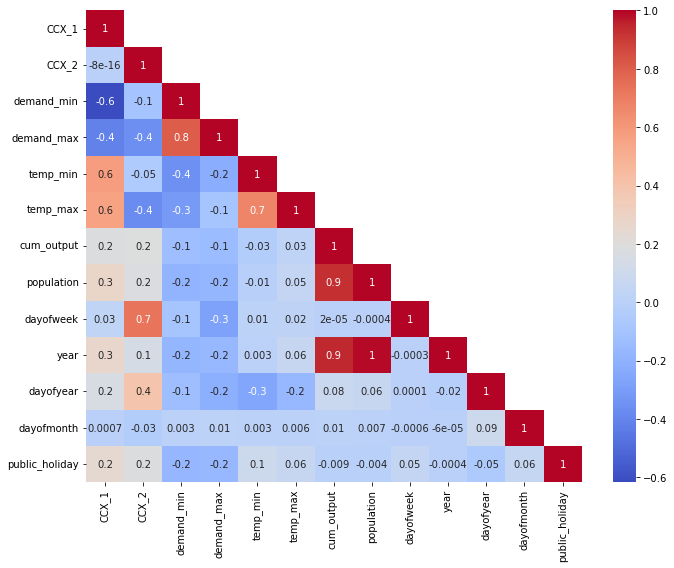

In [18]:
## Correlation between all fields , this will help analysis the relationship between the Transformed predictors and the responses
corr_X_df = ccX_df.corr(method='pearson')
plt.figure(figsize=(10,8))
X_df_lt = corr_X_df.where(np.tril(np.ones(corr_X_df.shape)).astype(bool))
sns.heatmap(X_df_lt,cmap="coolwarm",annot=True,fmt='.1g')
plt.tight_layout()
plt.savefig("Heatmap_Canonical_Correlates_from_X_and_data.jpg",
                    format='jpeg',
                    dpi=100)
## We see a correlation between demand and the transformed predictor variables

In [19]:
##Prepare transformed response for comparison with the predictor data
ccY_df = pd.DataFrame({"CCY_1":Y_c[:, 0],
                       "CCY_2":Y_c[:, 1],
                       "demand_min":df['demand_min'],
                       "demand_max":df['demand_max'],
                       "temp_min":df['temp_min'],
                       "temp_max":df['temp_max'],
                       "cum_output":df['cum_output'],
                       "population":df['population'],
                       "dayofweek":df['dayofweek'],
                       "year":df['year'],
                       "dayofyear":df['dayofyear'],
                       "dayofmonth":df['dayofmonth'],
                       "public_holiday":df['public_holiday']})

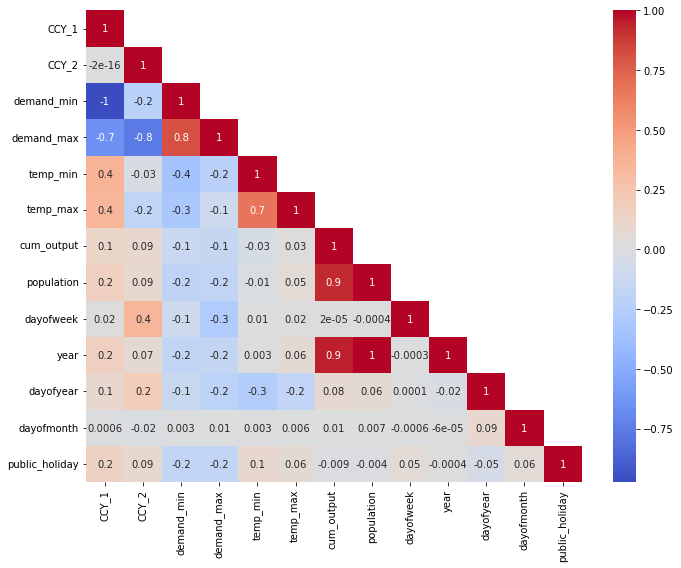

In [20]:
# compute correlation with Pandas corr()
corr_Y_df= ccY_df.corr(method='pearson') 
 
# Get lower triangular correlation matrix
Y_df_lt = corr_Y_df.where(np.tril(np.ones(corr_Y_df.shape)).astype(bool))
 
# make a lower triangular correlation heatmap with Seaborn
plt.figure(figsize=(10,8))
sns.heatmap(Y_df_lt,cmap="coolwarm",annot=True,fmt='.1g')
plt.tight_layout()
plt.savefig("Heatmap_Canonical_Correlates_from_Y_and_data.jpg",
                    format='jpeg',
                    dpi=100)
## Temp min and temp max show relatively strong correlations to the first linear combination
## day of the week shows a relativley strong correlation with the second linear combination

In [16]:
n = df.shape[0]
p = df_x.shape[1]
q = df_y.shape[1]
A = CCP.p_asym(base.c(np.corrcoef(X_c[:,0], Y_c[:,0])[0,1],np.corrcoef(X_c[:,1], Y_c[:,1])[0,1]),n,p,q, tstat = "Wilks")

Wilks' Lambda, using F-approximation (Rao's F):
              stat   approx df1  df2 p.value
1 to 2:  0.4584673 210.5169  18 7946       0
2 to 2:  0.7650914 152.5188   8 3974       0
